# Splitting The Data into Face (0) and Not Face (1)

In [29]:
import torch
import multiprocessing

def worker():
    try:
        import numpy as np
        print("Numpy available in subprocess")
    except ImportError:
        print("Numpy NOT available in subprocess")

if __name__ == "__main__":
    p = multiprocessing.Process(target=worker)
    p.start()
    p.join()


# Preprocessing Data to segeregate images

In [10]:
import os
import shutil

# Path to original folder with all images
source_dir = "original_dataset"
# Path for new structured dataset
target_dir = "dataset"

# Create target folders
os.makedirs(os.path.join(target_dir, "face"), exist_ok=True)
os.makedirs(os.path.join(target_dir, "non_face"), exist_ok=True)

# Keywords that indicate human images
face_keywords = ["human"]  # You can add more if needed

# Iterate over each image
for img in os.listdir(source_dir):
    img_path = os.path.join(source_dir, img)

    # Only process image files
    if img.lower().endswith(('.jpg', '.jpeg', '.png')):
        # Check if 'human' is in filename
        if any(keyword in img.lower() for keyword in face_keywords):
            dest = os.path.join(target_dir, "face")
        else:
            dest = os.path.join(target_dir, "non_face")

        # Copy image to the correct folder
        shutil.copy(img_path, dest)

print("✅ Images have been separated into face and non_face folders.")


✅ Images have been separated into face and non_face folders.


# Preprocessing Data

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
import os
img_height, img_width = 224, 224
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

train_gen = train_datagen.flow_from_directory(
    'dataset',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)

val_gen = train_datagen.flow_from_directory(
    'dataset',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)



Found 1827 images belonging to 2 classes.
Found 456 images belonging to 2 classes.


In [25]:
print(train_gen.class_indices)

{'face': 0, 'non_face': 1}


# Transfer Learning with Imagenet Model

In [3]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
base_model.trainable = False  # Freeze base layers

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(1, activation='sigmoid')(x)  # Binary output

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()




Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']      

# Fine Tuning Model

In [4]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10
)


Epoch 1/10


24/58 [===========>..................] - ETA: 23s - loss: 0.5536 - accuracy: 0.7174

G:\SkinSight\.venv\lib\site-packages\PIL\Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


58/58 [==============================] - 57s 934ms/step - loss: 0.3667 - accuracy: 0.8418 - val_loss: 0.1502 - val_accuracy: 0.9825
Epoch 2/10
58/58 [==============================] - 53s 918ms/step - loss: 0.0997 - accuracy: 0.9814 - val_loss: 0.0661 - val_accuracy: 0.9956
Epoch 3/10
58/58 [==============================] - 52s 891ms/step - loss: 0.0489 - accuracy: 0.9912 - val_loss: 0.0446 - val_accuracy: 0.9978
Epoch 4/10
58/58 [==============================] - 51s 882ms/step - loss: 0.0435 - accuracy: 0.9934 - val_loss: 0.0326 - val_accuracy: 0.9978
Epoch 5/10
58/58 [==============================] - 51s 889ms/step - loss: 0.0279 - accuracy: 0.9956 - val_loss: 0.0178 - val_accuracy: 1.0000
Epoch 6/10
58/58 [==============================] - 52s 888ms/step - loss: 0.0249 - accuracy: 0.9951 - val_loss: 0.0131 - val_accuracy: 0.9978
Epoch 7/10
58/58 [==============================] - 52s 891ms/step - loss: 0.0171 - accuracy: 0.9967 - val_loss: 0.0150 - val_accuracy: 0.9956
Epoch 8/10

In [5]:
base_model.trainable = True
for layer in base_model.layers[:-30]:  # Freeze all but last 30 layers
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=0.00001),  # lower LR
              loss='binary_crossentropy',
              metrics=['accuracy'])

history_fine = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=5
)


Epoch 1/5
58/58 [==============================] - 60s 954ms/step - loss: 0.3574 - accuracy: 0.8637 - val_loss: 0.0040 - val_accuracy: 1.0000
Epoch 2/5
58/58 [==============================] - 54s 939ms/step - loss: 0.0941 - accuracy: 0.9655 - val_loss: 0.0060 - val_accuracy: 1.0000
Epoch 3/5
58/58 [==============================] - 54s 933ms/step - loss: 0.0539 - accuracy: 0.9847 - val_loss: 0.0103 - val_accuracy: 0.9978
Epoch 4/5
58/58 [==============================] - 54s 932ms/step - loss: 0.0379 - accuracy: 0.9907 - val_loss: 0.0060 - val_accuracy: 1.0000
Epoch 5/5
58/58 [==============================] - 54s 929ms/step - loss: 0.0388 - accuracy: 0.9891 - val_loss: 0.0056 - val_accuracy: 1.0000


In [10]:
model.save(r"G:\SkinSight\models\face_detector.keras")  # Recommended


In [12]:
from tensorflow.keras.models import load_model

model_path = r"G:\SkinSight\models\face_detector.keras"  # Update if needed
model = load_model(model_path)


# Testing Model

In [24]:
import numpy as np
from tensorflow.keras.preprocessing import image

# Image size should match what was used during training (e.g., 224x224)
img_height, img_width = 224, 224
img_path = r"G:\SkinSight\test2.jpeg.jpeg"  # Replace with your test image path

# Load and preprocess image
img = image.load_img(img_path, target_size=(img_height, img_width))
img_array = image.img_to_array(img) / 255.0  # Normalize
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# Make prediction
prediction = model.predict(img_array)

if prediction < 0.5:
    print("✅ Face Detected")
else:
    print("❌ Not a Face")


1/1 [==============================] - 0s 38ms/step
❌ Not a Face


# Imports and Configuration Transfer Learning

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import os
# Dataset paths
data_dir = 'dataset/Oily-Dry-Skin-Types'
train_dir = os.path.join(data_dir, 'train')
valid_dir = os.path.join(data_dir, 'valid')
test_dir = os.path.join(data_dir, 'test')

# Hyperparameters
num_classes = 5
batch_size = 16
num_epochs = 30
learning_rate = 1e-4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Data Transformation

In [2]:
# Data augmentation for training
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


# Load Dataset

In [3]:
train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
val_dataset = datasets.ImageFolder(valid_dir, transform=val_transforms)
test_dataset = datasets.ImageFolder(test_dir, transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

classes = train_dataset.classes
print("Classes:", classes)


Classes: ['acne', 'burned', 'dry', 'normal', 'oily']


# Model Config

In [4]:
# Pretrained ResNet50
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)
model = model.to(device)


# Loss And Optimizer

In [5]:
# Optional: weighted loss if classes are imbalanced
class_counts = [len([label for _, label in train_dataset.samples if label==i]) for i in range(num_classes)]
class_weights = [sum(class_counts)/c for c in class_counts]
class_weights = torch.tensor(class_weights).float().to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)


# Training

In [6]:
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    # ---- Training ----
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)

    epoch_train_loss = running_loss / len(train_dataset)
    train_losses.append(epoch_train_loss)

    # ---- Validation ----
    model.eval()
    val_loss = 0.0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            all_preds.extend(outputs.argmax(dim=1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_val_loss = val_loss / len(val_dataset)
    val_losses.append(epoch_val_loss)
    scheduler.step(epoch_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} - "
          f"Train Loss: {epoch_train_loss:.4f} "
          f"Val Loss: {epoch_val_loss:.4f}")


Epoch 1/30 - Train Loss: 1.0372 Val Loss: 0.8990
Epoch 2/30 - Train Loss: 0.8549 Val Loss: 0.8248
Epoch 3/30 - Train Loss: 0.7539 Val Loss: 0.7589
Epoch 4/30 - Train Loss: 0.6542 Val Loss: 0.6684
Epoch 5/30 - Train Loss: 0.6451 Val Loss: 0.6261
Epoch 6/30 - Train Loss: 0.5680 Val Loss: 0.6686
Epoch 7/30 - Train Loss: 0.5496 Val Loss: 0.5648
Epoch 8/30 - Train Loss: 0.4788 Val Loss: 0.6797
Epoch 9/30 - Train Loss: 0.4097 Val Loss: 0.6725
Epoch 10/30 - Train Loss: 0.4254 Val Loss: 0.8644
Epoch 11/30 - Train Loss: 0.4222 Val Loss: 0.5636
Epoch 12/30 - Train Loss: 0.3600 Val Loss: 0.6122
Epoch 13/30 - Train Loss: 0.3490 Val Loss: 0.6026
Epoch 14/30 - Train Loss: 0.3482 Val Loss: 0.6484
Epoch 15/30 - Train Loss: 0.3447 Val Loss: 0.6300
Epoch 16/30 - Train Loss: 0.2711 Val Loss: 0.5925
Epoch 17/30 - Train Loss: 0.2414 Val Loss: 0.5911
Epoch 18/30 - Train Loss: 0.2248 Val Loss: 0.5664
Epoch 19/30 - Train Loss: 0.2185 Val Loss: 0.6356
Epoch 20/30 - Train Loss: 0.1826 Val Loss: 0.5672
Epoch 21/

# Evaluation Metrics

Classification Report:
              precision    recall  f1-score   support

        acne       0.99      0.98      0.98       290
      burned       0.50      0.50      0.50         4
         dry       0.88      0.72      0.79       209
      normal       0.83      0.85      0.84       332
        oily       0.74      0.85      0.79       239

    accuracy                           0.86      1074
   macro avg       0.79      0.78      0.78      1074
weighted avg       0.86      0.86      0.86      1074



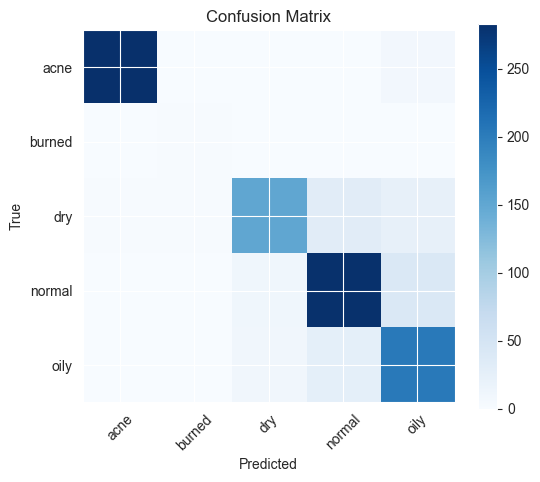

In [7]:
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=classes))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
plt.xticks(np.arange(num_classes), classes, rotation=45)
plt.yticks(np.arange(num_classes), classes)
plt.ylabel("True")
plt.xlabel("Predicted")
plt.show()


# Save Model

In [5]:
torch.save(model.state_dict(), "models/skin_type_classifier.pth")


# Test on Test Dataset 

Test Accuracy: 87.66%
Test Classification Report:
              precision    recall  f1-score   support

        acne       0.99      0.98      0.99       142
      burned       0.67      1.00      0.80         4
         dry       0.95      0.71      0.81       106
      normal       0.80      0.93      0.86       170
        oily       0.83      0.83      0.83       121

    accuracy                           0.88       543
   macro avg       0.85      0.89      0.86       543
weighted avg       0.89      0.88      0.88       543



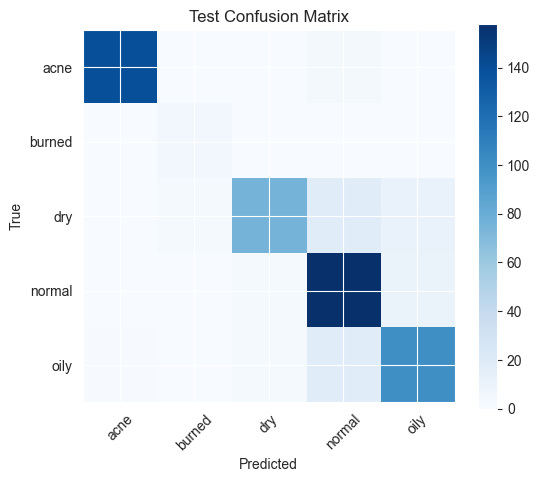

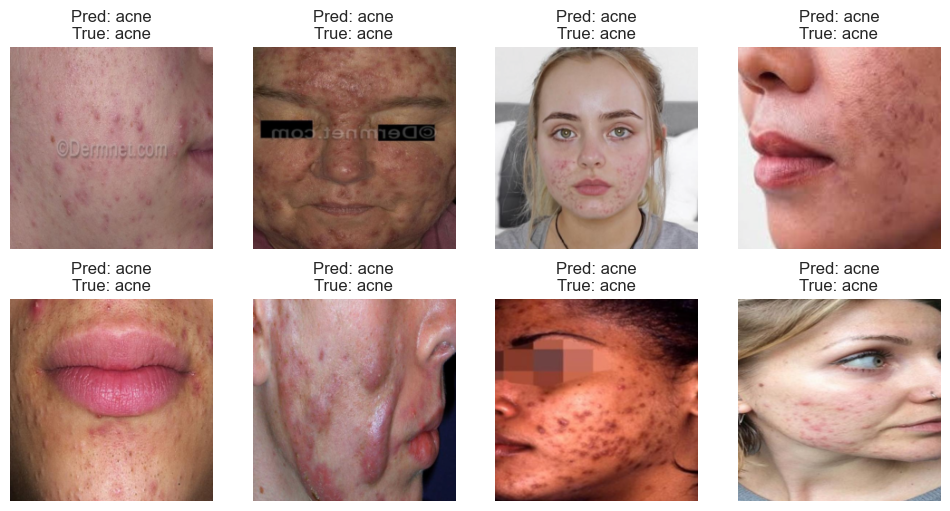

In [11]:
# Make sure the model is in eval mode
model.eval()

all_test_preds, all_test_labels = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds = outputs.argmax(dim=1)
        all_test_preds.extend(preds.cpu().numpy())
        all_test_labels.extend(labels.cpu().numpy())

# Test Accuracy
test_acc = np.mean(np.array(all_test_preds) == np.array(all_test_labels))
print(f"Test Accuracy: {test_acc*100:.2f}%")

# Detailed classification report
print("Test Classification Report:")
print(classification_report(all_test_labels, all_test_preds, target_names=classes))

# Confusion Matrix
cm = confusion_matrix(all_test_labels, all_test_preds)
plt.figure(figsize=(6,5))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title("Test Confusion Matrix")
plt.colorbar()
plt.xticks(np.arange(num_classes), classes, rotation=45)
plt.yticks(np.arange(num_classes), classes)
plt.ylabel("True")
plt.xlabel("Predicted")
plt.show()

# Optional: show predictions for first few images
import matplotlib.pyplot as plt

def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title:
        plt.title(title)
    plt.axis('off')

# Display first 8 test images with predictions
dataiter = iter(test_loader)
images, labels = next(dataiter)
outputs = model(images.to(device))
preds = outputs.argmax(dim=1).cpu()

plt.figure(figsize=(12,6))
for idx in range(8):
    plt.subplot(2,4,idx+1)
    imshow(images[idx], title=f"Pred: {classes[preds[idx]]}\nTrue: {classes[labels[idx]]}")
plt.show()


test_dr.jpeg --> Predicted skin type: acne
test_no.jpg --> Predicted skin type: normal
test_oi.jpeg --> Predicted skin type: oily


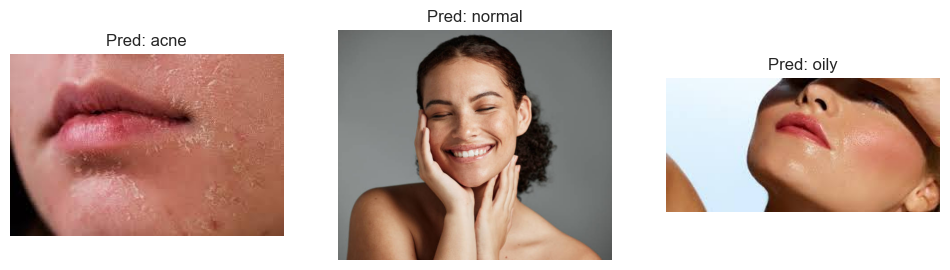

In [12]:
# ----- Imports -----
import torch
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import os
import numpy as np

# ----- Parameters -----
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = 'models/skin_type_classifier.pth'  # your saved model
num_classes = 5
classes = ['acne', 'burned', 'dry', 'normal', 'oily']  # same order as training

# ----- Transforms -----
test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# ----- Load Model -----
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, num_classes)
model.load_state_dict(torch.load(model_path, map_location=device))
model = model.to(device)
model.eval()

# ----- Function to process single image -----
def process_image(img_path):
    image = Image.open(img_path).convert("RGB")
    image = test_transforms(image)
    image = image.unsqueeze(0)  # add batch dimension
    return image

# ----- Function to predict single image -----
def predict_image(img_path, model, classes):
    image = process_image(img_path).to(device)
    with torch.no_grad():
        output = model(image)
        pred = output.argmax(dim=1).item()
    return classes[pred]

# ----- List of custom images -----
custom_images = [
    'test_dr.jpeg',
    'test_no.jpg',
    'test_oi.jpeg'
    # add more image paths here
]

# ----- Predict and print results -----
for img_path in custom_images:
    prediction = predict_image(img_path, model, classes)
    print(f"{os.path.basename(img_path)} --> Predicted skin type: {prediction}")

# ----- Optional: Display images with predictions -----
plt.figure(figsize=(12,6))
for idx, img_path in enumerate(custom_images):
    image = Image.open(img_path).convert("RGB")
    pred = predict_image(img_path, model, classes)
    plt.subplot(1, len(custom_images), idx+1)
    plt.imshow(image)
    plt.title(f"Pred: {pred}")
    plt.axis('off')
plt.show()
